# RNN for time series

<AxesSubplot:title={'center':'f(x) time series'}, xlabel='Time unites', ylabel='Sales'>

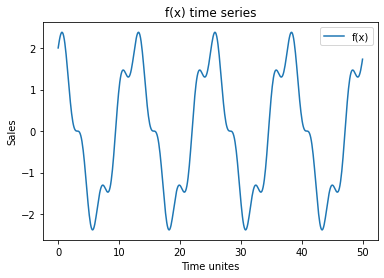

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

f = lambda t: .5*np.sin(2*t)+2*np.cos(.5*t)
x = np.linspace(0, 50, 500)
df = pd.DataFrame(f(x), index=x, columns= ["f(x)"])
df.plot(title = "f(x) time series", xlabel = "Time unites", ylabel = "Sales")

## Train|test split

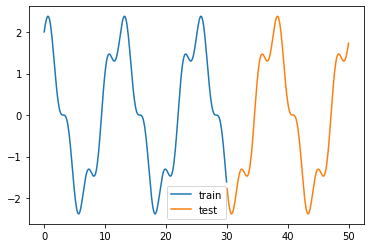

In [13]:
test_split = 200
df_train = df.iloc[:-test_split]
df_test = df.iloc[-test_split:]

ax = plt.axes()
df_train.plot(ax = ax)
df_test.plot(ax = ax)
plt.legend(["train", "test"])

## Scale data

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

scaled_train.shape, scaled_test.shape, scaled_test.min(), scaled_test.max()

((300, 1), (200, 1), 0.00011292154516773234, 0.9994100860551354)

## Time series batches

format: (batch_size, time_steps, dimensionality)

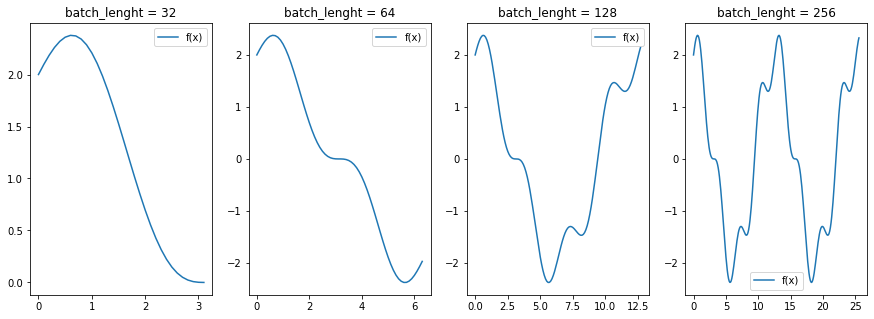

In [16]:
batch_lengths = [32, 64, 128, 256]
_, axes = plt.subplots(1,4, figsize=(15,5))

for batch_lenght, ax in zip(batch_lengths, axes):
    df_train.iloc[:batch_lenght].plot(ax=ax)
    ax.set_title(f"{batch_lenght = }")

In [28]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

batch_lenght, batch_size = 128, 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length = batch_lenght, batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length = batch_lenght, batch_size=batch_size)

X, y = train_generator[0]

X.shape, y.shape

((1, 128, 1), (1, 1))

In [22]:
X[0, -3:, 0], scaled_train[batch_lenght-3:batch_lenght].flatten()

(array([0.91183131, 0.93277341, 0.95216592]),
 array([0.91183131, 0.93277341, 0.95216592]))

In [25]:
y, scaled_train[batch_lenght]

(array([[0.96918959]]), array([0.96918959]))

## RNN model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def RNN_model(RNN_layers):
    model = Sequential()
    model.add(RNN_layers)
    model.add(Dense(1)) # Linear Layer
    model.compile(loss = "mse", optimizer = "adam")
    return model

RNN_layers = SimpleRNN(batch_lenght, return_sequences = False, input_shape = (None, 1))
model = RNN_model(RNN_layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(train_generator, epochs = 10, validation_data=test_generator)

Epoch 1/10
172/172 [==============================] - 6s 25ms/step - loss: 0.0343 - val_loss: 9.1382e-04
Epoch 2/10
172/172 [==============================] - 4s 25ms/step - loss: 3.5162e-04 - val_loss: 5.0022e-05
Epoch 3/10
172/172 [==============================] - 5s 27ms/step - loss: 1.8693e-04 - val_loss: 5.8166e-05
Epoch 4/10
172/172 [==============================] - 4s 24ms/step - loss: 2.2337e-04 - val_loss: 2.7093e-04
Epoch 5/10
172/172 [==============================] - 4s 25ms/step - loss: 3.3077e-04 - val_loss: 9.6773e-05
Epoch 6/10
172/172 [==============================] - 4s 24ms/step - loss: 7.8442e-05 - val_loss: 1.6093e-05
Epoch 7/10
172/172 [==============================] - 4s 25ms/step - loss: 1.6879e-04 - val_loss: 3.4586e-05
Epoch 8/10
172/172 [==============================] - 4s 24ms/step - loss: 1.3816e-04 - val_loss: 9.0294e-05
Epoch 9/10
172/172 [==============================] - 5s 26ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/10
172/172 [==========

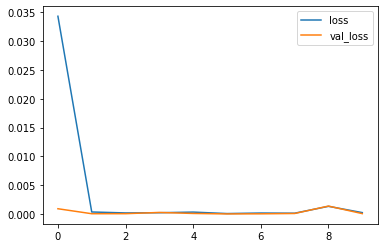

In [32]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot();

## Predictions

In [33]:
predictions = np.zeros([len(scaled_test), 1])
first_batch = scaled_train[-batch_lenght:]
print(f"{first_batch.shape=}")
new_batch = first_batch[None, :]
print(f"{new_batch.shape=}")

for i, _ in enumerate(df_test.values):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis = 1)

y_pred = scaler.inverse_transform(predictions)
y_pred[:3], df_test[:3].values

first_batch.shape=(128, 1)
new_batch.shape=(1, 128, 1)


(array([[-1.76299443],
        [-1.91479305],
        [-2.04951226]]),
 array([], shape=(0, 1), dtype=float64))

In [35]:
df_test.head(3)

,f(x),preds_RNN
30.060120,-1.766205,-1.762994
30.160321,-1.913366,-1.914793
30.260521,-2.044668,-2.049512


<AxesSubplot:>

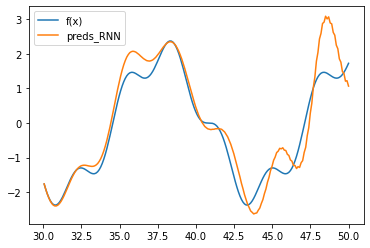

In [34]:
df_test.insert(df_test.shape[1], "preds_RNN", y_pred)
df_test.plot()

<AxesSubplot:>

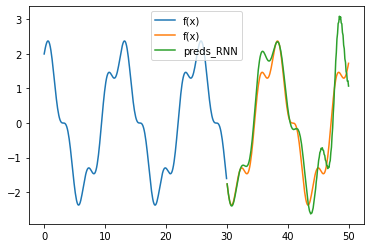

In [36]:
ax = df_train.plot()
df_test.plot(ax=ax)

## Forecasting

- predicting into the unknown future
- train on all data

In [38]:
from tensorflow.keras.layers import LSTM

LSTM_layer = LSTM(batch_lenght, return_sequences = False, input_shape = (None, 1))
model = RNN_model(LSTM_layer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [40]:
scaler = MinMaxScaler()
all_data = scaler.fit_transform(df)

all_data_generator = TimeseriesGenerator(all_data, all_data, length = batch_lenght, batch_size = batch_size)

model.fit(all_data_generator, epochs=5)

Epoch 1/5
372/372 [==============================] - 17s 45ms/step - loss: 9.0774e-04
Epoch 2/5
372/372 [==============================] - 17s 46ms/step - loss: 3.7128e-04
Epoch 3/5
372/372 [==============================] - 18s 49ms/step - loss: 1.4971e-04
Epoch 4/5
372/372 [==============================] - 18s 48ms/step - loss: 3.1911e-05
Epoch 5/5
372/372 [==============================] - 21s 57ms/step - loss: 2.6428e-04


In [48]:
steps_in_future = 200

predictions = np.zeros([steps_in_future, 1])
first_batch = all_data[-batch_lenght:]
new_batch = first_batch[None, :]

for i in range(steps_in_future):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis = 1)

y_pred = scaler.inverse_transform(predictions)

In [53]:
x_future = np.linspace(50.1, 50.1 + steps_in_future*.1, num= steps_in_future)
df_forecast = pd.DataFrame(y_pred, columns= ["Forecast"], index = x_future)
df_forecast.head()

,Forecast
50.100000,2.260492
50.200503,2.491664
50.301005,2.803874
50.401508,3.174591
50.502010,3.596001


<AxesSubplot:>

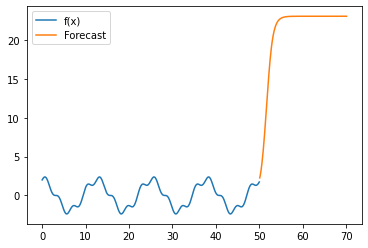

In [54]:
ax = df.plot()
df_forecast.plot(ax=ax)

<AxesSubplot:>

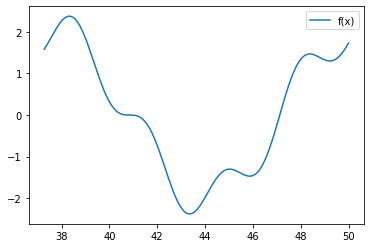

In [52]:
df.iloc[-batch_lenght:].plot()